In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixture1DAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture1D/../utils.py'>

In [2]:
w = 1/2
sigma = 1
weights = np.array([w, 1-w])

In [3]:
m = 6
d = 1
LSI = 1 + (np.exp(m**2)+1)/2
LSI

2155615773557599.0

In [4]:
def gm1d_density(xx, m, w):
    return w*norm.pdf(xx, loc = 0, scale = 1) + (1-w)*norm.pdf(xx, loc = m, scale = 1)

xx = np.linspace(-3, 10, 100)
yy = gm1d_density(xx, m, w)
dx = xx[1]-xx[0]

In [5]:
ms = np.array([np.zeros(d), m*np.ones(d)])
Sigmas = np.array([sigma*np.eye(d), sigma*np.eye(d)])

In [6]:
N = 1000
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
Niter = 5000
gamma = 0.01

In [7]:
### SMC-WFR
start = time.time()
wfr_x, wfr_w = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
end = time.time()
end-start

47.9763867855072

In [15]:
### SMC-ULA
start = time.time()
smcula_x, smcula_w = algo.SMC_ULA(gamma, Niter, ms, Sigmas, weights, X0)
end = time.time()
end-start

1.759016990661621

In [16]:
### SMC-MALA
start = time.time()
smcmala_x, smcmala_w = algo.SMC_MALA(gamma, Niter, ms, Sigmas, weights, X0)
end = time.time()
end-start

6.084166049957275

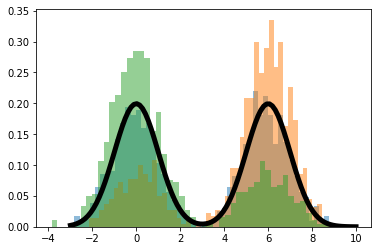

In [17]:
plt.hist(wfr_x[-1, :, :].flatten(), density = True, weights = wfr_w[-1, :], bins = 50, alpha = 0.5);
plt.hist(smcula_x[-1, :, :].flatten(), density = True, weights = smcula_w[-1, :], bins = 50, alpha = 0.5);
plt.hist(smcmala_x[-1, :, :].flatten(), density = True, weights = smcmala_w[-1, :], bins = 50, alpha = 0.5);
plt.plot(xx, yy, c = 'black', lw = 5)

In [18]:
kl_wfr = np.zeros(Niter)
kl_smcula = np.zeros(Niter)
kl_smcmala = np.zeros(Niter)
for j in range(Niter):
    kde_wfr = stats.gaussian_kde(wfr_x[j, :], weights = wfr_w[j, :])
    kl_wfr[j] = dx*np.sum(kde_wfr(xx)*(np.log(kde_wfr(xx))-np.log(yy)))
    kde_smcula = stats.gaussian_kde(smcula_x[j, :], weights = smcula_w[j, :])
    kl_smcula[j] = dx*np.sum(kde_smcula(xx)*(np.log(kde_smcula(xx))-np.log(yy)))
    kde_smcmala = stats.gaussian_kde(smcmala_x[j, :], weights = smcmala_w[j, :])
    kl_smcmala[j] = dx*np.sum(kde_smcmala(xx)*(np.log(kde_smcmala(xx))-np.log(yy)))

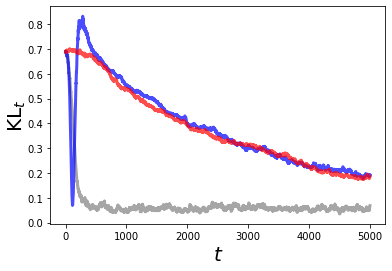

In [20]:
plt.plot(kl_wfr, label = 'SMC-WFR', color = 'gray', alpha = 0.7, lw = 3)
plt.plot(kl_smcula, label = 'SMC-ULA', color = 'blue', alpha = 0.7, lw = 3)
plt.plot(kl_smcmala, label = 'SMC-MALA', color = 'red', alpha = 0.7, lw = 3)
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('KL$_t$', fontsize = 20, labelpad=-1)
# plt.savefig('SMC_WFR_gaussianmix_alternatives.pdf', bbox_inches="tight")